In [12]:
import matplotlib.pyplot as plt
from os import getcwd
import torch
from tqdm import tqdm
from torch.distributions import multivariate_normal

from algorithm_package.algorithm_package import paper_algorithm
from energy_package.energy_package import two_param
from rf_package.rf_package import planar_flow
from plot_animation_package.plot_animation_package import density_2D


from numpy.random import uniform
import numpy as np
import torch.autograd as autograd
from  torch.distributions import multivariate_normal
import torch.optim as optim
from os import getcwd, makedirs

In [13]:
def NF_MCMC_algorithm(model_name, beta, U, BC, energy_parameters, flow, initial_data, base_distribution, time_step, k_max, k_lang, epsilon):
    #all operations must act on the whole array of lattices, hence proposed_model_configuration_amongst_zeros and other weird stuff
    
    ### ADDED
    kl_div_list = np.zeros(k_max)

    path = getcwd()+'\\saved_models\\'+model_name
    makedirs(path)

    def gradU(configuration):
        return autograd.grad(U(configuration, energy_parameters), configuration)[0]

    n, N = initial_data.shape

    normal_distribution_for_langevin = multivariate_normal.MultivariateNormal(loc=torch.zeros(N), covariance_matrix=torch.eye(N))

    array_of_model_configurations = torch.zeros(k_max,n,N)
    array_of_model_configurations[0] = initial_data
    array_of_model_configurations.requires_grad = True

    optimizer = optim.Adam(flow.parameters(), lr=epsilon)

    history = torch.zeros(k_max, n)
    #history[k,i] = 0 => Dynamic Langevin step
    #history[k,i] = 1 => Static Langevin step
    #history[k,i] = 2 => Dynamic Flow step
    #history[k,i] = 3 => Static Flow step

    for k in tqdm(range(1,k_max)):
        for i in range(n):
            proposed_model_configuration_amongst_zeros = torch.zeros(k_max,n,N)
            if k % k_lang == 0:
                history[k,i] += 2
                proposed_model_configuration_amongst_zeros[k,i] = flow(base_distribution.sample())[0]
                
                proposed_model_configuration_amongst_zeros[k,i] = BC(proposed_model_configuration_amongst_zeros[k,i])

                acceptance_rate = torch.exp(log_rho_hat(array_of_model_configurations[k-1,i])
                                            - log_rho_hat(proposed_model_configuration_amongst_zeros[k,i])
                                            + beta*U(array_of_model_configurations[k-1, i], energy_parameters)
                                            - beta*U(proposed_model_configuration_amongst_zeros[k, i], energy_parameters))

            else:
                proposed_model_configuration_amongst_zeros[k,i] = ( array_of_model_configurations[k-1,i]
                                                                    - time_step * gradU(array_of_model_configurations[k-1, i])
                                                                    + torch.sqrt(2*torch.tensor(time_step)) * normal_distribution_for_langevin.sample())

                proposed_model_configuration_amongst_zeros[k,i] = BC(proposed_model_configuration_amongst_zeros[k,i])

                acceptance_rate = torch.exp(beta*U(array_of_model_configurations[k-1, i], energy_parameters)
                                            - beta*U(proposed_model_configuration_amongst_zeros[k, i], energy_parameters))

            if uniform() > acceptance_rate:
                    proposed_model_configuration_amongst_zeros[k,i] = array_of_model_configurations[k-1,i]
                    history[k,i] += 1
            array_of_model_configurations = array_of_model_configurations + proposed_model_configuration_amongst_zeros

        def log_rho_hat(x):
            return base_distribution.log_prob((flow.inverse(x))[0])+flow.inverse(x)[1]
        
        #OPTIMISATION
        optimizer.zero_grad()
        x = array_of_model_configurations[k-1,:].clone().detach().requires_grad_(False)
        loss = - (base_distribution.log_prob(flow.inverse(x)[0]) + flow.inverse(x)[1]).mean()
        kl_div_list[k] = loss.detach().numpy()
        loss.backward()
        optimizer.step()
    
    torch.save(flow.state_dict(), path+'\\model.pt')
    torch.save(array_of_model_configurations, path+'\\array_of_model_configurations.pt')
    torch.save(history, path+'\\history.pt')

    file_name = path+"\\parameters.txt"
    with open(file_name, 'w') as file:
        file.write(f"beta\t{beta}\n")
        file.write(f"n\t{n}\n")
        file.write(f"N\t{N}\n")
        file.write(f"time_step\t{time_step}\n")
        file.write(f"k_max\t{k_max}\n")
        file.write(f"k_lang\t{k_lang}\n")
        file.write(f"epsilon\t{epsilon}\n")
        file.write("energy_parameters\t")
        file.write(str(energy_parameters))
    
    return kl_div_list, history, array_of_model_configurations.detach()

In [1]:
# MODEL PARAMETERS
data_dim = 2 #size of the parameter space
beta = 1
U = two_param.bistable_circle
BC = two_param.bistable_circle_BC
energy_parameters = []

# RF PARAMETERS
base_distribution = multivariate_normal.MultivariateNormal(loc=torch.zeros(data_dim), covariance_matrix=torch.eye(data_dim))
renormalization_flow = planar_flow.LayeredPlanarFlow(data_dim)
epsilon = 2e-2 #gradient descent rate for RF parameters
n = 200 #number of initial samples

# MALA PARAMETERS
time_step = 1e-1
k_lang = 5
k_max = 50

# INITIALISATION
initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*20-10

base_file = 'multivariate_normal-LayeredPlanarFlow-convergence-v2'

# RUN
model_name = base_file+"\\"+'convergence'
model_file = getcwd()+"\\saved_models"+"\\"+model_name

RF_MCMC_parameters = [time_step, k_max, k_lang, epsilon]
kl_div_list, history, array_of_model_configurations = NF_MCMC_algorithm(model_name, beta, U, BC, energy_parameters, renormalization_flow, initial_data, base_distribution, *RF_MCMC_parameters)

NameError: name 'two_param' is not defined

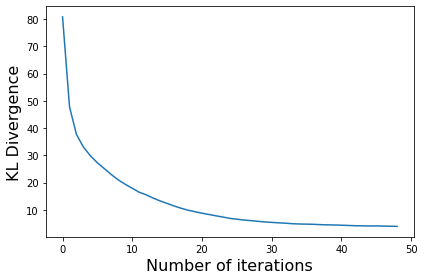

In [21]:
fig, ax = plt.subplots()

ax.set_xlabel('Number of iterations', fontsize=16)
ax.set_ylabel('KL Divergence', fontsize=16)
ax.plot(kl_div_list[1:])
plt.tight_layout()
fig.savefig(getcwd()+"\\saved_models"+"\\"+base_file+'\\convergence')

txt_file = getcwd()+"\\saved_models"+"\\"+base_file+'\\convergence.txt'
np.savetxt(txt_file, kl_div_list, delimiter="\t", header="kl_div")